In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

Thu Mar 23 12:44:59 PDT 2023


In [2]:
# from vivarium_research_prl import datatypes

# PRL V&V - Social Security Observer
Systematic validation

In [28]:
%cd /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
!ls -halt

/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
total 14G
drwxrwsr-x  2 albrja IHME-Simulationscience 4.0K Mar 22 16:44 .
-rw-r--r--  1 albrja IHME-Simulationscience  59M Mar 15 10:01 wic_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 1.5G Mar 15 10:01 tax_dependents_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.8G Mar 15 09:57 tax_w2_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 4.1G Mar 15 09:56 tax_1040_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 192M Mar 15 09:48 social_security_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience  35M Mar 15 09:36 household_survey_observer_cps.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.7M Mar 15 09:36 household_survey_observer_acs.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 638M Mar 15 09:36 decennial_census_observer.csv.bz2
drwx

In [29]:
%%time

df = pd.read_csv('social_security_observer.csv.bz2', low_memory=False, #dtype='category',
                 nrows=1_000_000
                )

CPU times: user 4.89 s, sys: 325 ms, total: 5.22 s
Wall time: 5.23 s


In [30]:
df

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth
0,786-77-6454,M,creation,Bingham,Peter,1921-05-13,2284_733465,1921-05-13
1,688-88-6377,D,creation,Bingham,Janice,1921-06-21,2284_733466,1921-06-21
2,651-33-9561,H,creation,Burdick,Anna,1921-07-13,2284_776885,1921-07-13
3,665-25-7858,M,creation,Tapia,Gertrude,1921-07-26,2284_869365,1921-07-26
...,...,...,...,...,...,...,...,...
999996,378-10-3757,C,death,Rhodes,Karen,2021-08-18,2284_499762,1948-12-10
999997,847-72-9612,S,death,Ayala-Rivera,Thomas,2021-08-18,2284_124489,1949-01-05
999998,811-81-0649,S,death,Horton,Ronald,2021-08-18,2284_165020,1949-02-14
999999,315-54-4731,M,death,Chaumont,Maureen,2021-08-18,2284_603412,1949-02-17


In [31]:
df.iloc[0].to_dict()

{'ssn': '786-77-6454',
 'middle_initial': 'M',
 'event_type': 'creation',
 'last_name': 'Bingham',
 'first_name': 'Peter',
 'event_date': '1921-05-13',
 'simulant_id': '2284_733465',
 'date_of_birth': '1921-05-13'}

# Known VV issues

* ssn could be an int, to save space/time
* event type is categorical, could specifiy when reading csv
* (names could also be treated as categorical)
* event_date might be better clipped to some date when SS started (somebody reading this data will realize that there was no SSA in 1921!)
* simulant_id could be an int (or float)

## Checking data type

In [32]:
df.dtypes

ssn               object
middle_initial    object
event_type        object
last_name         object
first_name        object
event_date        object
simulant_id       object
date_of_birth     object
dtype: object

## Checking SSN assignment
- Each SSN should only appear once or twice (i.e., could be assigned to two separate sim_ids in the instance that a sim dies and their SSN is given to a new sim)

In [33]:
df.ssn.value_counts()  # expect 1 and 2 values here

786-77-6454    2
141-87-9698    2
046-56-6824    2
703-78-7219    2
              ..
564-23-3351    1
744-28-0819    1
236-28-7659    1
712-26-2069    1
Name: ssn, Length: 987886, dtype: int64

In [34]:
ssn_occurrences = df.ssn.value_counts()
assert set(ssn_occurrences.unique()) == set([1,2]), 'expect each ssn to appear once or twice'

## Checking names 
- All 26 letters should be represented as a simulant middle initial
- Most common and least common first and last names should be as expected
- Most common and least common first and last names stratified by race/ethnicity should be as expected

In [35]:
df.middle_initial.nunique()  # expect 26

26

In [36]:
assert df.middle_initial.nunique()  == 26, 'expect all 26 letters to appear as a middle initial for somebody'

In [37]:
df.first_name.value_counts()

Michael    14213
John       12734
James      12461
Robert     11623
           ...  
Trane          1
Phoua          1
Sabree         1
Khaza          1
Name: first_name, Length: 11788, dtype: int64

[]

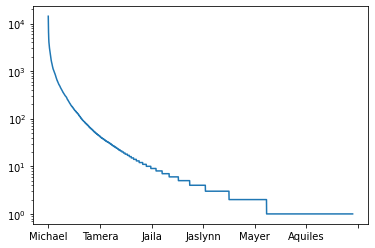

In [38]:
df.first_name.value_counts().plot()
plt.semilogy()

## Checking event date distribution
- should see far more creation/death events toward end of simulation: but why?
- check how often death events are happening: check mortality rates?
- check how often creation events are happening: when creation event_date != dob, check migration rates. When creation event_date == dob, check fertility rates.

In [39]:
df.event_date = pd.to_datetime(df.event_date)

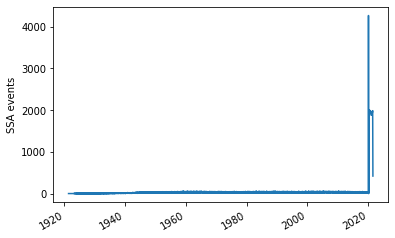

In [40]:
df.event_date.value_counts().sort_index().plot()
plt.ylabel('SSA events');

In [41]:
df.event_date.value_counts()

2020-03-04    4270
2020-07-22    2001
2020-05-27    1993
2021-07-21    1989
              ... 
1923-01-03       1
1922-12-31       1
1923-12-19       1
1921-05-13       1
Name: event_date, Length: 35389, dtype: int64

In [42]:
max_day = df.event_date.value_counts().index[0]

df[df.event_date == max_day]

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth
961235,891-23-3325,L,creation,Luchin,Maurice,2020-03-04,2284_248,2020-03-04
961236,766-69-0018,A,creation,Harris,Darian,2020-03-04,2284_925,2020-03-04
961237,334-50-2250,C,creation,Pestana,Javier,2020-03-04,2284_986,2020-03-04
961238,616-18-2931,M,creation,Hamilton,Mila,2020-03-04,2284_1233,2020-03-04
...,...,...,...,...,...,...,...,...
965501,864-19-2082,M,creation,Lewis,Mila,2020-03-04,2284_968972,2020-03-04
965502,277-48-4523,S,creation,Roberts,Jaliyah,2020-03-04,2284_969275,2020-03-04
965503,736-62-3154,L,creation,Thompson,Arya,2020-03-04,2284_969329,2020-03-04
965504,466-10-2218,J,creation,Abston,Emilia,2020-03-04,2284_969736,2020-03-04


In [43]:
second_to_max_day = df.event_date.value_counts().index[1]

df[df.event_date == second_to_max_day]

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth
972274,318-16-7924,P,death,Fitch,Amelia,2020-07-22,2284_508944,1923-05-18
972275,514-08-8114,D,death,Sommer,Susie,2020-07-22,2284_471801,1923-06-06
972276,221-67-7051,G,death,Conroy,Rita,2020-07-22,2284_705740,1923-06-19
972277,684-47-3570,J,death,Stephens,Ross,2020-07-22,2284_785602,1923-08-19
...,...,...,...,...,...,...,...,...
974271,734-04-8562,A,creation,Ward,Wren,2020-07-22,2284_1006176,2020-08-18
974272,167-11-9504,C,creation,Minarik,Theodore,2020-07-22,2284_1006209,2020-08-18
974273,485-89-9645,R,creation,Flanagan,Ryder,2020-07-22,2284_1006268,2020-08-18
974274,291-16-4229,A,creation,Mata,Kenai,2020-07-22,2284_1006315,2020-08-18


## Checking age distributions of creation/death events 
- for event_type == death, we should see mostly old people
- for event_type == creation, we should see population growth with more people born or immigrating in recent years

In [44]:
df['dob'] = pd.to_datetime(df.date_of_birth)

In [45]:
df['year_of_birth'] = df.dob.dt.year

<AxesSubplot:>

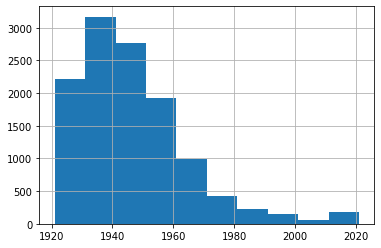

In [46]:
df[df.event_type == 'death'].year_of_birth.hist()

<AxesSubplot:>

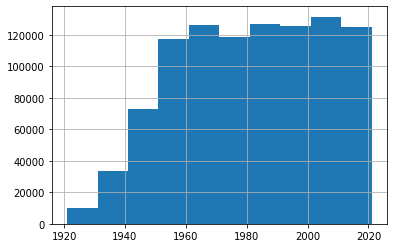

In [47]:
df[df.event_type == 'creation'].year_of_birth.hist()

## Checking validity of creation/death events
- creation events should have event_date == date_of_birth, unless they are an immigrant
- death event should always be after creation event for one simulant_id

In [48]:
creation_only = df[df.event_type == 'creation']
# creation_only[creation_only.event_date == creation_only.date_of_birth] # This is resulting in an error: TypeError: Categoricals can only be compared if 'categories' are the same.
creation_only.event_date.dtypes

dtype('<M8[ns]')

In [49]:
creation_only.dob.dtypes

dtype('<M8[ns]')

## Checking migration patterns 
- look at US-born and foreign-born simulants: 
    - for event_type == creation: 
        if event_date == year_of_birth, this indicates the simulant is US-born
        if event_date > year_of_birth, this indicates the simulant is foreign-born 

In [50]:
# Finding US-born simulants
creation_only 

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth,dob,year_of_birth
0,786-77-6454,M,creation,Bingham,Peter,1921-05-13,2284_733465,1921-05-13,1921-05-13,1921
1,688-88-6377,D,creation,Bingham,Janice,1921-06-21,2284_733466,1921-06-21,1921-06-21,1921
2,651-33-9561,H,creation,Burdick,Anna,1921-07-13,2284_776885,1921-07-13,1921-07-13,1921
3,665-25-7858,M,creation,Tapia,Gertrude,1921-07-26,2284_869365,1921-07-26,1921-07-26,1921
...,...,...,...,...,...,...,...,...,...,...
999894,495-49-6328,S,creation,Sawyer,Patsy,2021-08-18,2284_1025175,1943-03-12,1943-03-12,1943
999923,106-77-3116,A,creation,Rigney,Claire,2021-08-18,2284_1024982,1944-08-07,1944-08-07,1944
999934,187-94-1864,B,creation,Busch,Shirley,2021-08-18,2284_1025105,1945-03-15,1945-03-15,1945
999983,712-26-2069,D,creation,Williams,Betty,2021-08-18,2284_1025154,1948-01-12,1948-01-12,1948


In [51]:
creation_only = creation_only[creation_only.event_date.astype('datetime64[ns]') == creation_only.dob.astype('datetime64[ns]')]

In [52]:
creation_only[creation_only.event_date == creation_only.dob]

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth,dob,year_of_birth
0,786-77-6454,M,creation,Bingham,Peter,1921-05-13,2284_733465,1921-05-13,1921-05-13,1921
1,688-88-6377,D,creation,Bingham,Janice,1921-06-21,2284_733466,1921-06-21,1921-06-21,1921
2,651-33-9561,H,creation,Burdick,Anna,1921-07-13,2284_776885,1921-07-13,1921-07-13,1921
3,665-25-7858,M,creation,Tapia,Gertrude,1921-07-26,2284_869365,1921-07-26,1921-07-26,1921
...,...,...,...,...,...,...,...,...,...,...
998690,111-58-3661,J,creation,Fletcher,Moshe,2021-07-21,2284_1023454,2021-07-21,2021-07-21,2021
998691,530-39-3088,L,creation,Feehan,Kaylee,2021-07-21,2284_1023483,2021-07-21,2021-07-21,2021
998692,304-29-0148,M,creation,Arora,Zoe,2021-07-21,2284_1023566,2021-07-21,2021-07-21,2021
998693,630-25-9626,E,creation,Townsend,Penelope,2021-07-21,2284_1023584,2021-07-21,2021-07-21,2021


967031 rows / 987886 rows means about 97.9% of creation events are birth events. 